# 머신 러닝 교과서 2판

# 9장 - 웹 애플리케이션에 머신 러닝 모델 내장하기

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch09/ch09.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch09/ch09.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 8장 정리 - 영화 리뷰 분류를 위한 모델 훈련하기
- 학습된 사이킷런 추정기 저장
- 데이터를 저장하기 위해 SQLite 데이터베이스 설정
- 플라스크 웹 애플리케이션 개발
    - 첫 번째 플라스크 애플리케이션
    - 폼 검증과 화면 출력
- 영화 리뷰 분류기를 웹 애플리케이션으로 만들기
- 공개 서버에 웹 애플리케이션 배포
    - 영화 분류기 업데이트
- 요약

In [1]:
from IPython.display import Image

플래스크(Flask) 웹 애플리케이션 코드는 다음 디렉토리에 있습니다:
    
- `1st_flask_app_1/`: 간단한 플래스크 웹 애플리케이션
- `1st_flask_app_2/`: `1st_flask_app_1`에 폼 검증과 렌더링을 추가하여 확장한 버전
- `movieclassifier/`: 웹 애플리케이션에 내장한 영화 리뷰 분류기
- `movieclassifier_with_update/`: `movieclassifier`와 같지만 초기화를 위해 sqlite 데이터베이스를 사용합니다.

웹 애플리케이션을 로컬에서 실행하려면 `cd`로 (위에 나열된) 각 디렉토리에 들어가서 메인 애플리케이션 스크립트를 실행합니다.

    cd ./1st_flask_app_1
    python app.py
    
터미널에서 다음같은 내용일 출력됩니다.
    
     * Running on http://127.0.0.1:5000/
     * Restarting with reloader
     
웹 브라우저를 열고 터미널에 출력된 주소(일반적으로 http://127.0.0.1:5000/)를 입력하여 웹 애플리케이션에 접속합니다.

**이 튜토리얼로 만든 예제 애플리케이션 데모는 다음 주소에서 볼 수 있습니다: http://haesun.pythonanywhere.com/**.

<br>
<br>

# 8장 정리 - 영화 리뷰 분류를 위한 모델 훈련하기

이 절은 8장의 마지막 섹션에서 훈련한 로지스틱 회귀 모델을 다시 사용합니다. 이어지는 코드 블럭을 실행하여 다음 절에서 사용할 모델을 훈련시키겠습니다.

**노트**

다음 코드는 8장에서 만든 `movie_data.csv` 데이터셋을 사용합니다.

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [2]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch09/movie_data.csv.gz

In [3]:
import gzip


with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/work/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [6]:
next(stream_docs(path='movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

`pyprind`는 주피터 노트북에서 진행바를 출력하기 위한 유틸리티입니다. `pyprind` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [9]:
#!pip install pyprind

In [10]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:24


In [11]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('정확도: %.3f' % clf.score(X_test, y_test))

정확도: 0.868


In [12]:
clf = clf.partial_fit(X_test, y_test)

### 노트

pickle 파일을 만드는 것이 조금 까다로울 수 있기 때문에 `pickle-test-scripts/` 디렉토리에 올바르게 환경이 설정되었는지 확인하는 간단한 테스트 스크립트를 추가했습니다. 기본적으로 `movie_data` 데이터 일부를 포함하고 있고 `ch08`의 관련된 코드를 정리한 버전입니다.

다음처럼 실행하면

    python pickle-dump-test.py

`movie_data_small.csv`에서 작은 분류 모델을 훈련하고 2개의 pickle 파일을 만듭니다.

    stopwords.pkl
    classifier.pkl

그다음 아래 명령을 실행하면

    python pickle-load-test.py

다음 2줄이 출력되어야 합니다:

    Prediction: positive
    Probability: 85.71%

<br>
<br>

# 학습된 사이킷런 추정기 저장

앞에서 로지스틱 회귀 모델을 훈련한 후에 분류기, 불용어, 포터 어간 추출기, `HashingVectorizer`를 로컬 디스크에 직렬화된 객체로 저장합니다. 나중에 웹 애플리케이션에서 학습된 분류기를 이용하겠습니다.

In [13]:
import pickle
import os

dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

그다음 나중에 임포트할 수 있도록 별도의 파일에 `HashingVectorizer`를 저장합니다.

In [14]:
%%writefile movieclassifier/vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(
                os.path.join(cur_dir, 
                'pkl_objects', 
                'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Overwriting movieclassifier/vectorizer.py


이전 코드 셀을 실행한 후에 객체가 올바르게 저장되었는지 확인하기 위해 IPython 노트북 커널을 재시작할 수 있습니다.

먼저 현재 파이썬 디렉토리를 `movieclassifer`로 변경합니다:

In [15]:
import os
os.chdir('movieclassifier')

In [16]:
import pickle
import re
import os
from vectorizer import vect

clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [17]:
import numpy as np
label = {0:'음성', 1:'양성'}

example = ["I love this movie. It's amazing."]
X = vect.transform(example)
print('예측: %s\n확률: %.2f%%' %\
      (label[clf.predict(X)[0]], 
       np.max(clf.predict_proba(X))*100))

예측: 양성
확률: 95.55%


<br>
<br>

# 데이터를 저장하기 위해 SQLite 데이터베이스 설정

이 코드를 실행하기 전에 현재 위치가 `movieclassifier` 디렉토리인지 확인합니다.

In [18]:
os.getcwd()

'/home/work/github/python-ml-3/ch09/movieclassifier'

In [19]:
import sqlite3
import os

conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS review_db')
c.execute('CREATE TABLE review_db (review TEXT, sentiment INTEGER, date TEXT)')

example1 = 'I love this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 1))

example2 = 'I disliked this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 0))

conn.commit()
conn.close()

In [20]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM review_db WHERE date BETWEEN '2017-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()

conn.close()

In [21]:
print(results)

[('I love this movie', 1, '2020-11-30 05:38:47'), ('I disliked this movie', 0, '2020-11-30 05:38:47')]


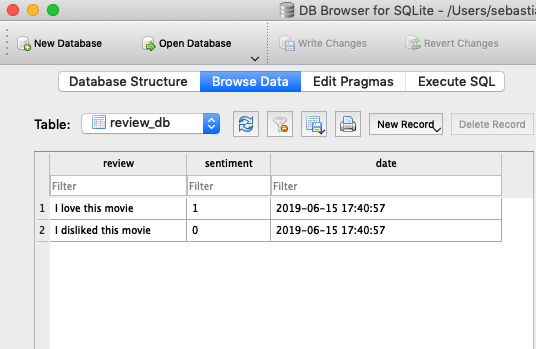

In [22]:
Image(filename='../images/09_01.png', width=700) 

<br>

# 플라스크 웹 애플리케이션 개발

...

## 첫 번째 플라스크 애플리케이션

...

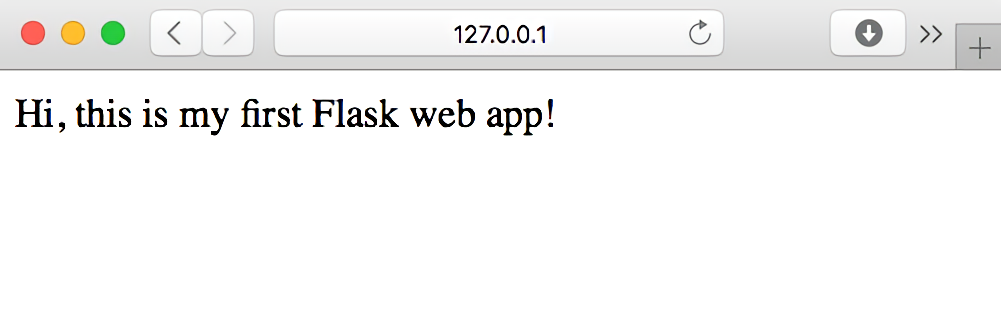

In [23]:
Image(filename='../images/09_09.png', width=700) 

## 폼 검증과 화면 출력

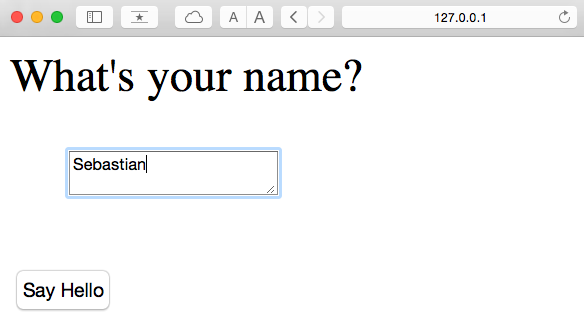

In [24]:
Image(filename='../images/09_02.png', width=400) 

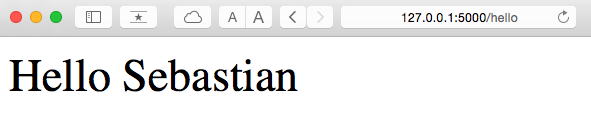

In [25]:
Image(filename='../images/09_03.png', width=400) 

<br>
<br>

## 화면 요약

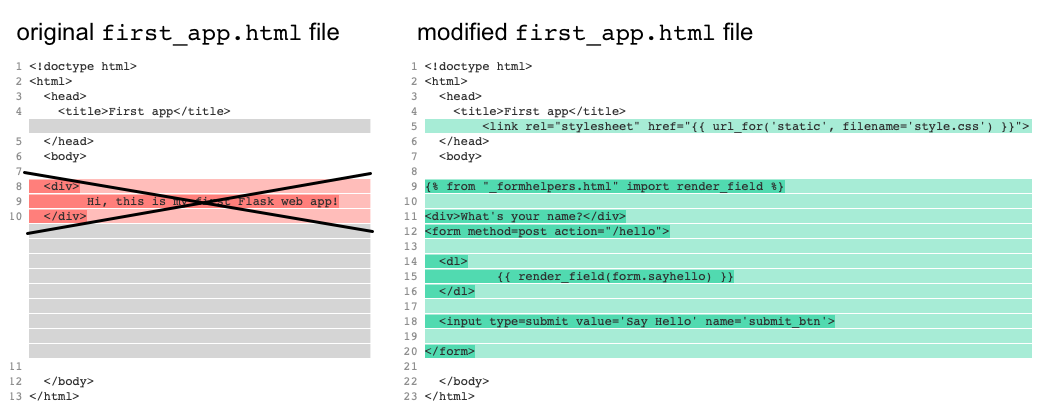

In [27]:
Image(filename='../images/09_11.png', width=800) 

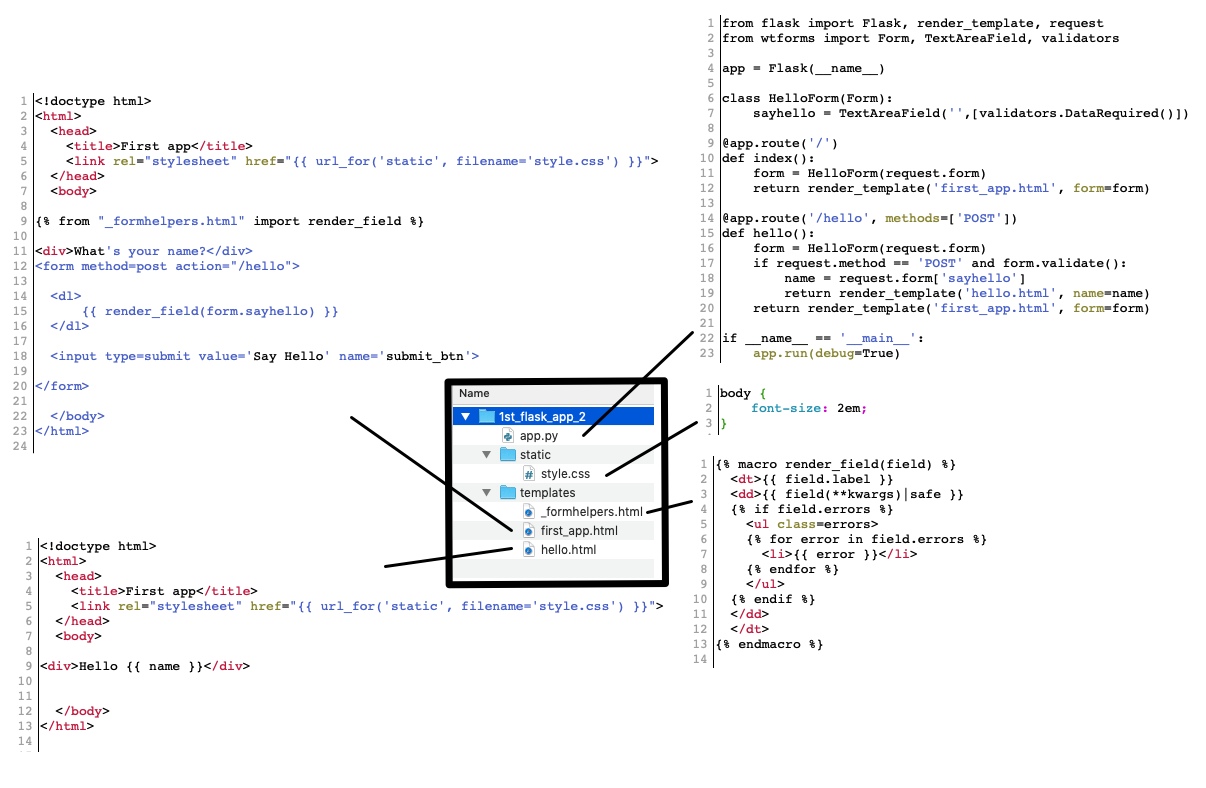

In [28]:
Image(filename='../images/09_12.png', width=800) 

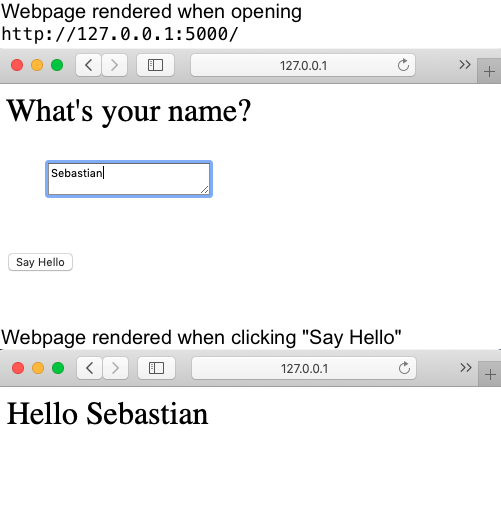

In [29]:
Image(filename='../images/09_13.png', width=400) 

# 영화 리뷰 분류기를 웹 애플리케이션으로 만들기

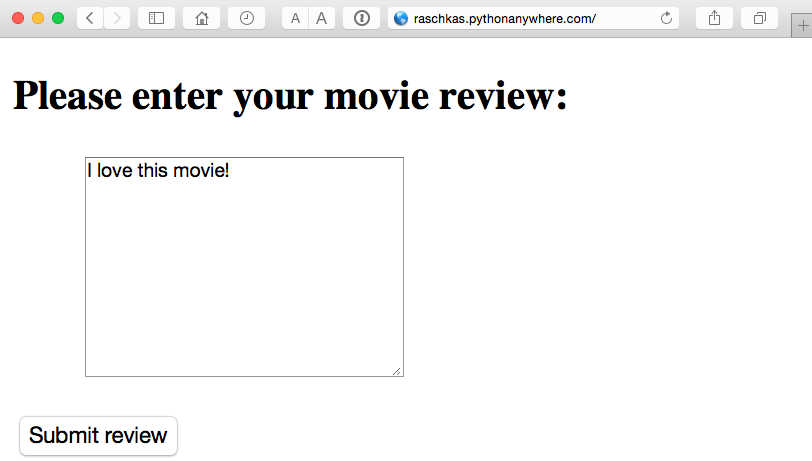

In [30]:
Image(filename='../images/09_04.png', width=400) 

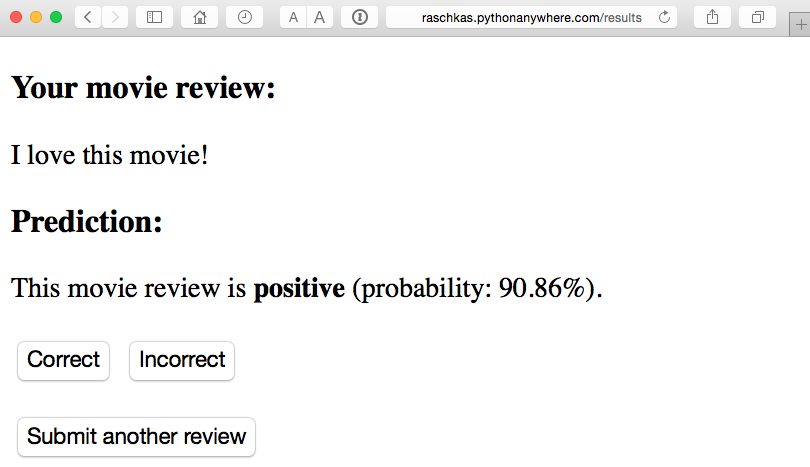

In [31]:
Image(filename='../images/09_05.png', width=400) 

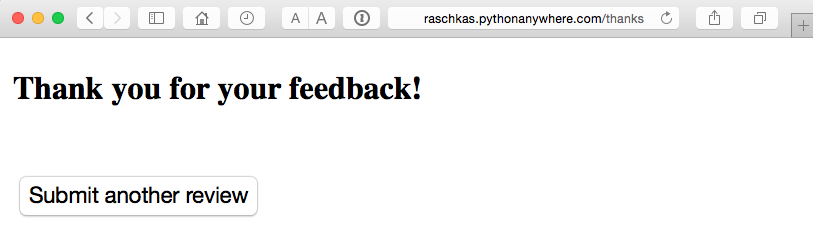

In [32]:
Image(filename='../images/09_06.png', width=400) 

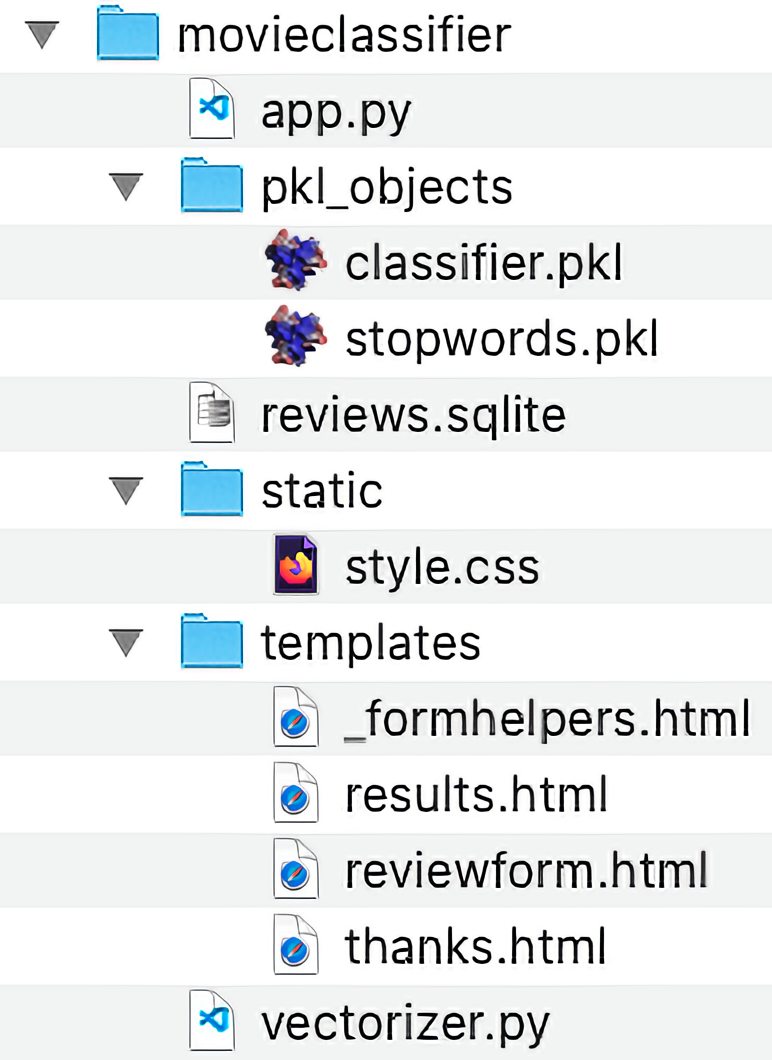

In [33]:
Image(filename='../images/09_07.png', width=200) 

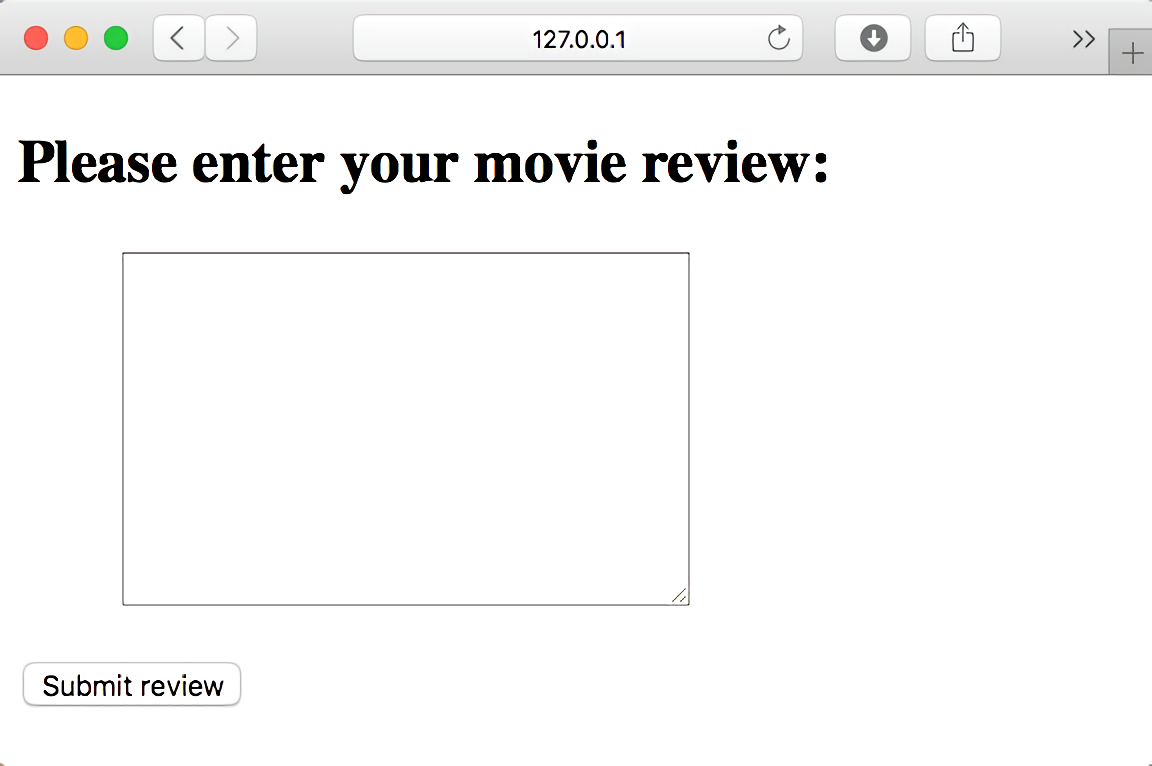

In [34]:
Image(filename='../images/09_10.png', width=400) 

<br>
<br>

# 공개 서버에 웹 애플리케이션 배포

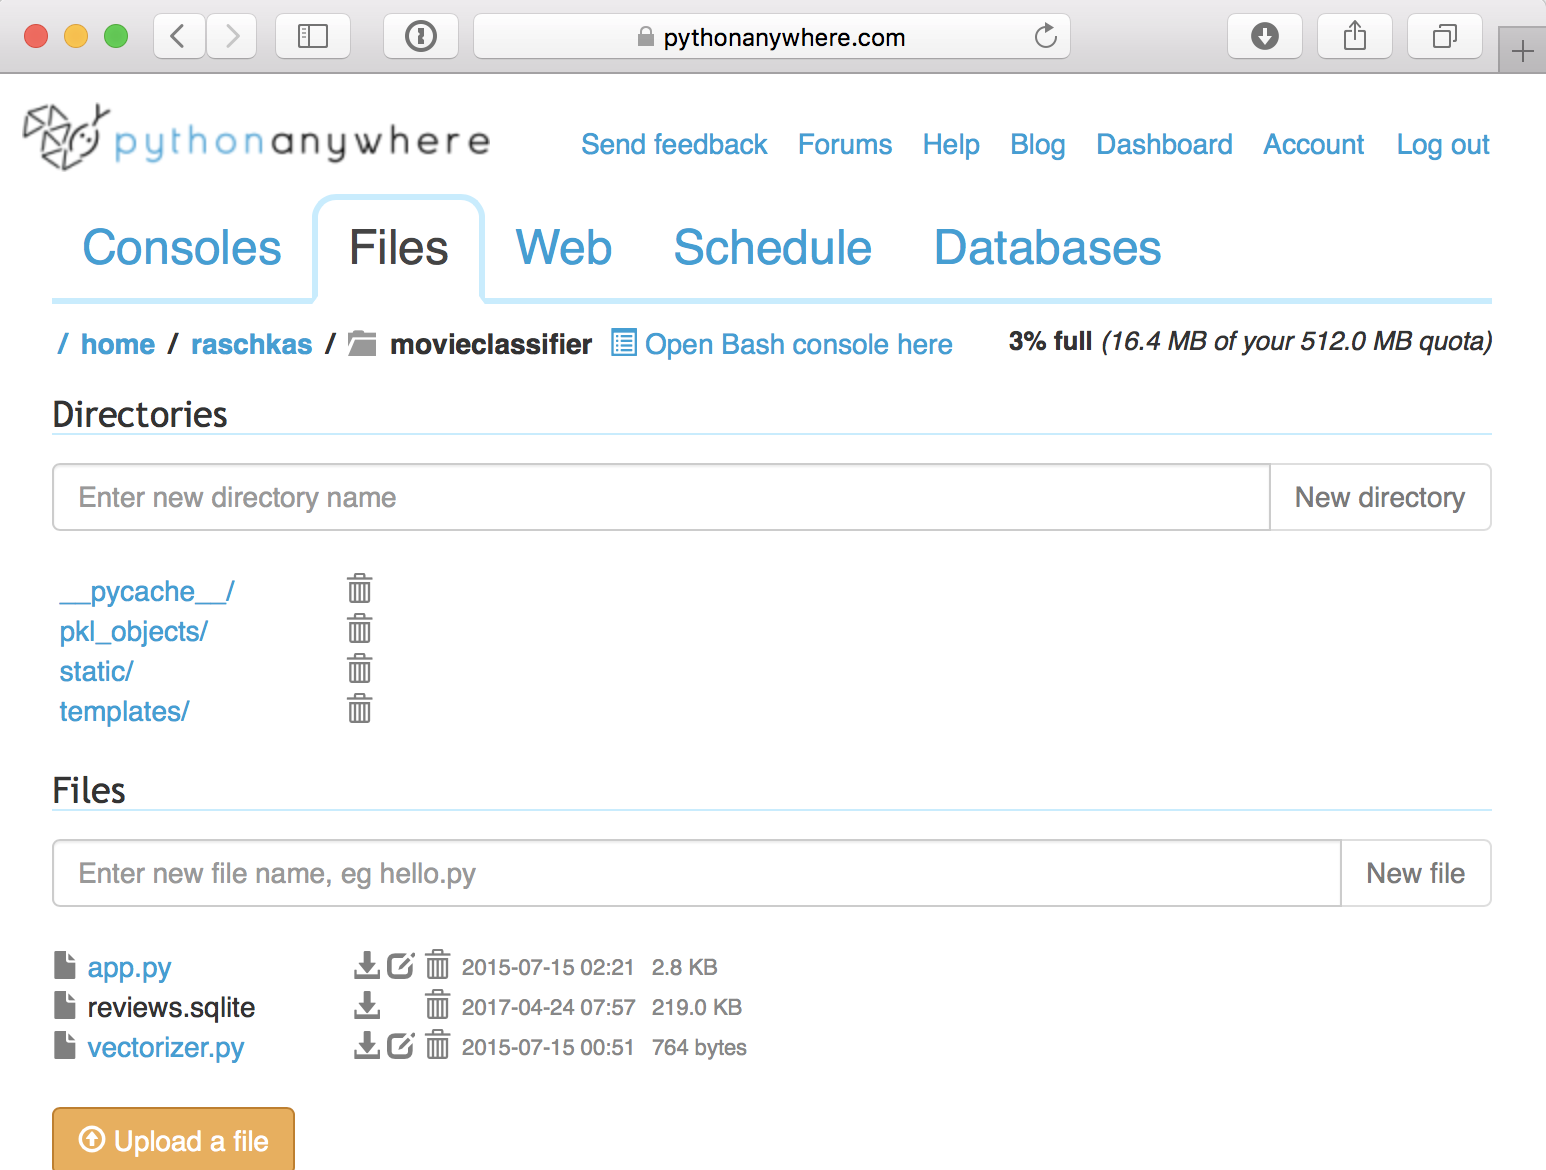

In [35]:
Image(filename='../images/09_08.png', width=600) 

<br>
<br>

## 영화 분류기 업데이트

다운로드한 깃허브 저장소에 들어있는 movieclassifier_with_update 디렉토리를 사용합니다(그렇지 않으면 `movieclassifier` 디렉토리를 복사해서 사용하세요).

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [36]:
#!cp -r ../movieclassifier ../movieclassifier_with_update

In [37]:
import shutil

os.chdir('..')

if not os.path.exists('movieclassifier_with_update'):
    os.mkdir('movieclassifier_with_update')
os.chdir('movieclassifier_with_update')

if not os.path.exists('pkl_objects'):
    os.mkdir('pkl_objects')

shutil.copyfile('../movieclassifier/pkl_objects/classifier.pkl',
                './pkl_objects/classifier.pkl')

shutil.copyfile('../movieclassifier/reviews.sqlite',
                './reviews.sqlite')

'./reviews.sqlite'

SQLite 데이터베이스에 저장된 데이터로 분류기를 업데이트하는 함수를 정의합니다:

In [38]:
import pickle
import sqlite3
import numpy as np

# 로컬 디렉토리에서 HashingVectorizer를 임포트합니다
from vectorizer import vect

def update_model(db_path, model, batch_size=10000):

    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('SELECT * from review_db')
    
    results = c.fetchmany(batch_size)
    while results:
        data = np.array(results)
        X = data[:, 0]
        y = data[:, 1].astype(int)
    
        classes = np.array([0, 1])
        X_train = vect.transform(X)
        clf.partial_fit(X_train, y, classes=classes)
        results = c.fetchmany(batch_size)
    
    conn.close()
    return None

모델을 업데이트합니다:

In [39]:
cur_dir = '.'

# app.py 파일에 이 코드를 삽입했다면 다음 경로를 사용하세요.

# import os
# cur_dir = os.path.dirname(__file__)

clf = pickle.load(open(os.path.join(cur_dir,
                 'pkl_objects',
                 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

update_model(db_path=db, model=clf, batch_size=10000)

# classifier.pkl 파일을 업데이트하려면 다음 주석을 해제하세요.

# pickle.dump(clf, open(os.path.join(cur_dir, 
#             'pkl_objects', 'classifier.pkl'), 'wb')
#             , protocol=4)

<br>
<br>

# 요약

<br>
...
<br>